In [237]:
from allensdk.core.brain_observatory_cache import BrainObservatoryCache
from allensdk.core.brain_observatory_nwb_data_set import BrainObservatoryNwbDataSet
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import json
import math
import os
# import scipy
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split
from scipy.stats import zscore
from tqdm import tqdm


In [2]:
filter_json = """
[
    {
        "field": "area",
        "op": "in",
        "value": [
            "VISp"
        ]
    },
    {
        "field": "tld1_name",
        "op": "in",
        "value": [
            "Cux2-CreERT2",
            "Slc17a7-IRES2-Cre"
        ]
    }
]
"""
       
filters = json.loads(filter_json)
boc = BrainObservatoryCache(manifest_file="brain_observatory/manifest.json")
cells = boc.get_cell_specimens(filters=filters)
cells_df = pd.DataFrame(cells)
cells_df

,all_stim,area,cell_specimen_id,donor_full_genotype,dsi_dg,experiment_container_id,failed_experiment_container,g_dsi_dg,g_osi_dg,g_osi_sg,...,specimen_id,tfdi_dg,time_to_peak_ns,time_to_peak_sg,tld1_id,tld1_name,tld2_id,tld2_name,tlr1_id,tlr1_name
0,False,VISp,517406367,Cux2-CreERT2/wt;Camk2a-tTA/wt;Ai93(TITL-GCaMP6...,NaN,511507650,False,NaN,NaN,0.683686,...,495727026,NaN,0.26600,0.33250,177839004,Cux2-CreERT2,177837320,Camk2a-tTA,265943423,Ai93(TITL-GCaMP6f)
1,False,VISp,517406379,Cux2-CreERT2/wt;Camk2a-tTA/wt;Ai93(TITL-GCaMP6...,NaN,511507650,False,NaN,NaN,0.788170,...,495727026,NaN,0.29925,0.29925,177839004,Cux2-CreERT2,177837320,Camk2a-tTA,265943423,Ai93(TITL-GCaMP6f)
2,False,VISp,517406391,Cux2-CreERT2/wt;Camk2a-tTA/wt;Ai93(TITL-GCaMP6...,0.877959,511507650,False,0.507377,0.127260,NaN,...,495727026,0.438380,NaN,NaN,177839004,Cux2-CreERT2,177837320,Camk2a-tTA,265943423,Ai93(TITL-GCaMP6f)
3,False,VISp,517406400,Cux2-CreERT2/wt;Camk2a-tTA/wt;Ai93(TITL-GCaMP6...,NaN,511507650,False,NaN,NaN,0.498305,...,495727026,NaN,0.26600,0.36575,177839004,Cux2-CreERT2,177837320,Camk2a-tTA,265943423,Ai93(TITL-GCaMP6f)
4,False,VISp,517406405,Cux2-CreERT2/wt;Camk2a-tTA/wt;Ai93(TITL-GCaMP6...,NaN,511507650,False,NaN,NaN,NaN,...,495727026,NaN,NaN,NaN,177839004,Cux2-CreERT2,177837320,Camk2a-tTA,265943423,Ai93(TITL-GCaMP6f)
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11335,False,VISp,738949207,Cux2-CreERT2/wt;Camk2a-tTA/wt;Ai93(TITL-GCaMP6...,0.533129,712178509,False,0.273694,0.247268,0.825973,...,699502603,0.360599,0.29844,0.36476,177839004,Cux2-CreERT2,177837320,Camk2a-tTA,265943423,Ai93(TITL-GCaMP6f)
11336,False,VISp,738949239,Cux2-CreERT2/wt;Camk2a-tTA/wt;Ai93(TITL-GCaMP6...,NaN,712178509,False,NaN,NaN,0.289035,...,699502603,NaN,0.29844,NaN,177839004,Cux2-CreERT2,177837320,Camk2a-tTA,265943423,Ai93(TITL-GCaMP6f)
11337,False,VISp,738949290,Cux2-CreERT2/wt;Camk2a-tTA/wt;Ai93(TITL-GCaMP6...,NaN,712178509,False,NaN,NaN,NaN,...,699502603,NaN,NaN,NaN,177839004,Cux2-CreERT2,177837320,Camk2a-tTA,265943423,Ai93(TITL-GCaMP6f)
11338,False,VISp,738949318,Cux2-CreERT2/wt;Camk2a-tTA/wt;Ai93(TITL-GCaMP6...,0.562188,712178509,False,0.158478,0.242484,NaN,...,699502603,0.361589,NaN,NaN,177839004,Cux2-CreERT2,177837320,Camk2a-tTA,265943423,Ai93(TITL-GCaMP6f)


In [9]:
# cells_df.columns.unique().tolist()
# cont_ids = cells_df['experiment_container_id'].unique()
# experiments = boc.get_ophys_experiments(experiment_container_ids=cont_ids, include_failed=False, require_eye_tracking=False)
# exp_ids = [d['id'] for d in experiments]
# exp_ids = exp_ids[:30]
# exp_ids[-1]

510517131

In [17]:
saving_dir = r'D:\BrainObservatory\brain_observatory\ophys_experiment_data'
files = os.listdir(saving_dir)
exp_ids = [int(s[:-4]) for s in files]
exp_ids

[647155122,
 650389887,
 650512363,
 652094901,
 652842572,
 653053207,
 653125130,
 653173685,
 654920038,
 656381309,
 656939127,
 657082055,
 657469734,
 657649672,
 661437140,
 662107986,
 663479950,
 663485329,
 663868345,
 663873076,
 664404274,
 667364442,
 667376208,
 680156911,
 681673022,
 681674286,
 685494041,
 688678766,
 690045763]

In [20]:
bad_ids = []
for exp in tqdm(exp_ids):
    # boc.get_ophys_experiment_data(exp)
    try:
        boc.get_ophys_pupil_data(exp,  suppress_pupil_data=False)
    except Exception:
        bad_ids.append(exp)

100%|██████████| 29/29 [00:02<00:00, 11.74it/s]


In [21]:
exp_ids = [id for id in exp_ids if id not in bad_ids]

In [22]:
id = exp_ids[1]

In [57]:
exp  = boc.get_ophys_experiment_data(id)
dff = exp.get_dff_traces()
eye = boc.get_ophys_pupil_data(id, suppress_pupil_data=False)
stim = boc.get_ophys_experiment_stimuli(id)

In [79]:
spont = exp.get_stimulus_table('spontaneous').values[0]
spont

array([68880, 78057])

In [81]:
ts = dff[0][spont[0]:spont[1]]

In [164]:
def find_nearest(array,value):
    idx = np.searchsorted(array, value, side="left")
    if idx > 0 and (idx == len(array) or math.fabs(value - array[idx-1]) < math.fabs(value - array[idx])):
        return array[idx-1]
    else:
        return array[idx]

def nan_helper(y):
    """Helper to handle indices and logical indices of NaNs.

    Input:
        - y, 1d numpy array with possible NaNs
    Output:
        - nans, logical indices of NaNs
        - index, a function, with signature indices= index(logical_indices),
          to convert logical indices of NaNs to 'equivalent' indices
    Example:
        >>> # linear interpolation of NaNs
        >>> nans, x= nan_helper(y)
        >>> y[nans]= np.interp(x(nans), x(~nans), y[~nans])
    """

    return np.isnan(y), lambda z: z.nonzero()[0]

In [102]:
ts[-1] -eye_ts[-1]

-0.01367000000027474

In [98]:
eye_ts = (find_nearest(eye.index.tolist(), ts[0]), find_nearest(eye.index.tolist(), ts[-1]))
eye_sp = eye.loc[eye_ts[0]:eye_ts[1]]
eye_sp

,raw_eye_area,raw_pupil_area,raw_screen_coordinates_x_cm,raw_screen_coordinates_y_cm,raw_screen_coordinates_spherical_x_deg,raw_screen_coordinates_spherical_y_deg,filtered_eye_area,filtered_pupil_area,filtered_screen_coordinates_x_cm,filtered_screen_coordinates_y_cm,filtered_screen_coordinates_spherical_x_deg,filtered_screen_coordinates_spherical_y_deg
2230.32993,17836.844305,1059.005482,14.258803,10.104697,5.418540,3.854318,17836.844305,1059.005482,14.258803,10.104697,5.418540,3.854318
2230.36318,18015.220950,1042.247093,14.447952,10.161407,5.489844,3.875883,18015.220950,1042.247093,14.447952,10.161407,5.489844,3.875883
2230.39655,18052.292044,1047.766439,14.556250,10.433053,5.530060,3.979169,18052.292044,1047.766439,14.556250,10.433053,5.530060,3.979169
2230.42981,18257.162284,1043.150647,14.427111,10.163883,5.481967,3.876825,18257.162284,1043.150647,14.427111,10.163883,5.481967,3.876825
2230.46331,18210.999068,1052.019831,13.859059,9.476766,5.268923,3.615457,18210.999068,1052.019831,13.859059,9.476766,5.268923,3.615457
...,...,...,...,...,...,...,...,...,...,...,...,...
2526.66032,15763.620123,500.773870,18.777750,6.738375,7.129127,2.572428,15763.620123,500.773870,18.777750,6.738375,7.129127,2.572428
2526.69354,15678.603565,496.717467,19.131716,6.619386,7.262345,2.527062,15678.603565,496.717467,19.131716,6.619386,7.262345,2.527062
2526.72700,15709.853951,498.087845,19.600002,6.340981,7.438726,2.420906,15709.853951,498.087845,19.600002,6.340981,7.438726,2.420906
2526.76105,15683.190598,515.299970,18.570349,7.373717,7.049794,2.814602,15683.190598,515.299970,18.570349,7.373717,7.049794,2.814602


In [165]:
new_pupil = np.interp(ts, eye_sp.index.to_list(),  eye_sp['raw_pupil_area'])
nans, x= nan_helper(new_pupil)
new_pupil[nans]= np.interp(x(nans), x(~nans), new_pupil[~nans])
new_pupil = zscore(new_pupil, ddof=1, nan_policy = 'omit')




In [150]:
new_pupil

array([nan, nan, nan, ..., nan, nan, nan])

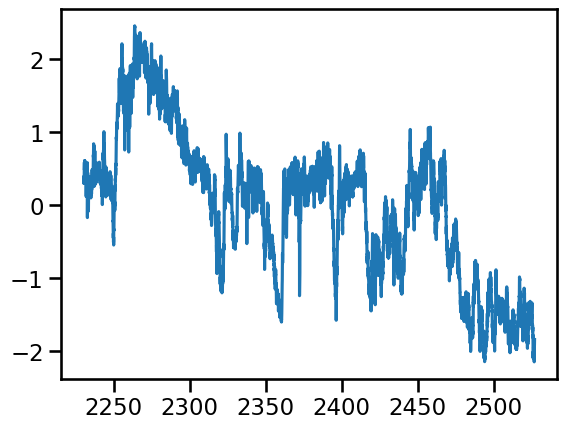

In [166]:
plt.plot(ts, new_pupil)
plt.plot(eye_sp.index.tolist(), eye_sp['raw_pupil_area'])

In [138]:
traces = dff[1][:,spont[0] : spont[-1]]
traces


(211, 9177)

In [140]:
pca = PCA()

components = pca.fit_transform(traces)
scree1 = np.cumsum(pca.explained_variance_ratio_)

pca.explained_variance_ratio_



array([7.9923443e-02, 3.5354953e-02, 3.2681637e-02, 3.1607885e-02,
       2.5140850e-02, 2.3214422e-02, 1.8190591e-02, 1.6469635e-02,
       1.4591254e-02, 1.3670394e-02, 1.2098753e-02, 1.0467644e-02,
       1.0029874e-02, 9.8597603e-03, 9.2575522e-03, 8.1618233e-03,
       7.1984986e-03, 7.1602757e-03, 6.9613005e-03, 6.6326130e-03,
       6.5784985e-03, 6.5240683e-03, 6.4146435e-03, 6.3545215e-03,
       6.2429048e-03, 6.0888380e-03, 6.0344376e-03, 5.8589326e-03,
       5.7745012e-03, 5.6577637e-03, 5.5143395e-03, 5.4663075e-03,
       5.4216846e-03, 5.3250371e-03, 5.2740290e-03, 5.2199573e-03,
       5.1161791e-03, 4.9407627e-03, 4.9122609e-03, 4.8690382e-03,
       4.8547913e-03, 4.7966442e-03, 4.7327508e-03, 4.7061741e-03,
       4.6890085e-03, 4.6393704e-03, 4.6138815e-03, 4.5349132e-03,
       4.5010117e-03, 4.4688922e-03, 4.4443505e-03, 4.4043022e-03,
       4.3450221e-03, 4.3118852e-03, 4.2624241e-03, 4.2369864e-03,
       4.2028842e-03, 4.1884854e-03, 4.1571110e-03, 4.1363565e

Text(0.5, 0, 'Number of components')

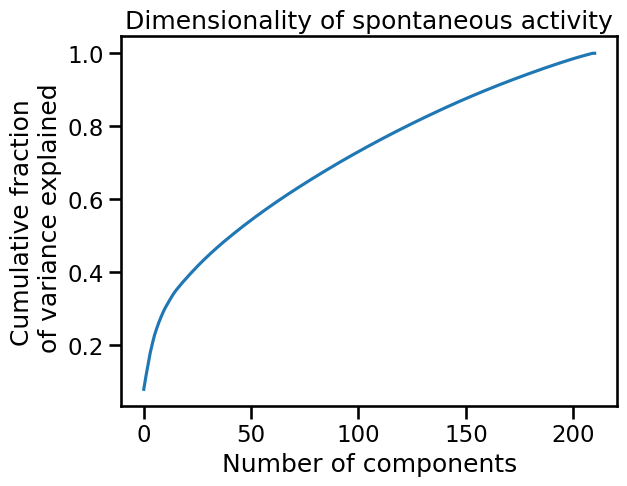

In [ ]:
f, ax = plt.subplots()

sns.set_context('talk')
sns.lineplot(scree1)


ax.set_title('Dimensionality of spontaneous activity')
ax.set_ylabel('Cumulative fraction\n of variance explained')
ax.set_xlabel('Number of components')

In [189]:
lr = LinearRegression()
train_dff = traces[:,:6000].T
train_pupil = new_pupil[:6000]
test_dff = traces[:,6001:].T
test_pupil = new_pupil[6001:]
lr.fit(train_dff, train_pupil)

LinearRegression()

In [192]:
pupil_pred = lr.predict(test_dff)

mean_squared_error(new_pupil[6001:],pupil_pred)

1.9987546641564766

In [193]:
r2_score(new_pupil[6001:],pupil_pred)

-1.944048325111309

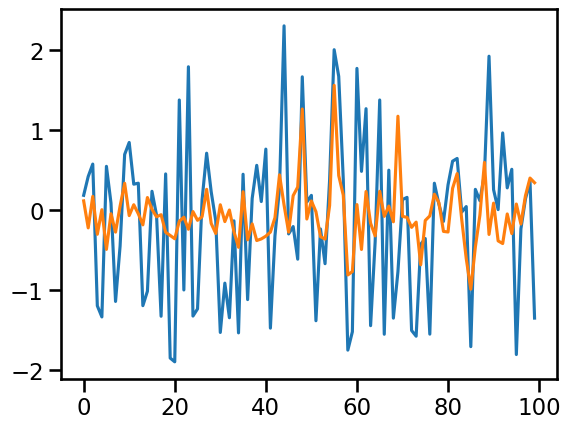

In [209]:
plt.plot(test_pupil[:100])
plt.plot(pupil_pred[:100])

In [254]:
train_dff, test_dff, train_pupil, test_pupil = train_test_split(traces[:,:-400].T, new_pupil[:-400], random_state=42)

In [258]:
r = Ridge(alpha=12, random_state = 42)
# train_dff = traces[:,:6000].T
# train_pupil = new_pupil[:6000]
# test_dff = traces[:,6001:].T
# test_pupil = new_pupil[6001:]
r.fit(train_dff, train_pupil)
pupil_pred = r.predict(traces[:,400:].T)
r.score(test_dff, test_pupil)

0.2256361132735838

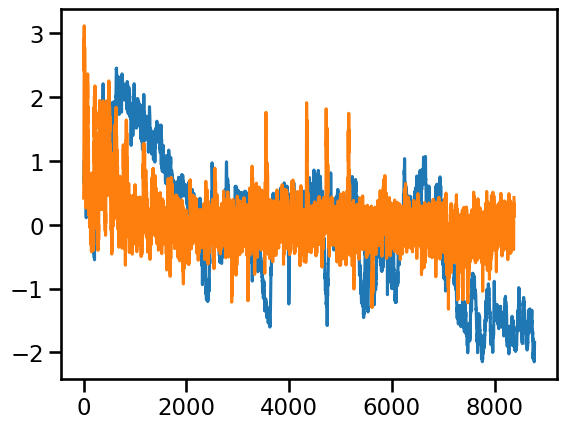

In [259]:
plt.plot(new_pupil[400:])
plt.plot(pupil_pred[400:])

In [262]:
l = Lasso(alpha = 3,random_state = 42)

l.fit(train_dff, train_pupil)
pupil_pred = l.predict(traces[:,400:].T)
l.score(test_dff, test_pupil)

-0.0005605705820617146

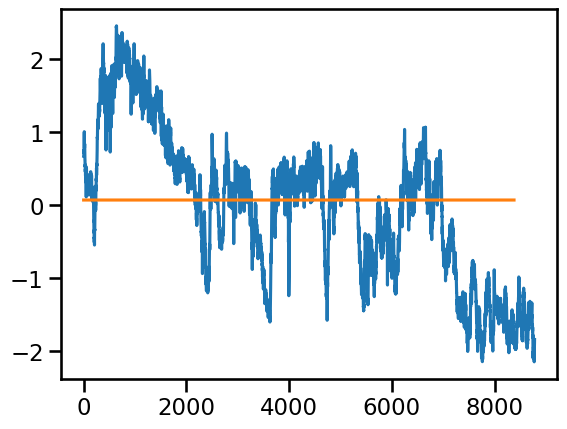

In [263]:
plt.plot(new_pupil[400:])
plt.plot(pupil_pred[400:])

In [264]:
rf = RandomForestRegressor(n_estimators =500, random_state = 42, oob_score = True, n_jobs  =10)

rf.fit(train_dff, train_pupil)
pupil_pred = rf.predict(traces[:,400:].T)
rf.score(test_dff, test_pupil)

0.39101954577828535

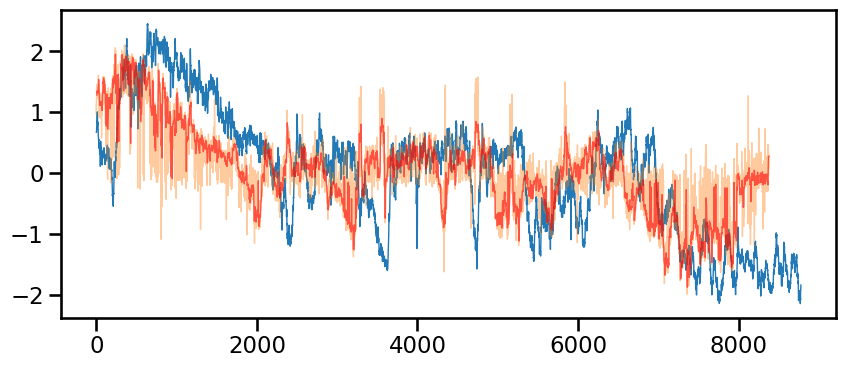

In [282]:
plt.subplots(figsize =  (10, 4))

plt.plot(new_pupil[400:] ,linewidth = 1, alpha = .99)
plt.plot(pupil_pred[400:], linewidth = 1, alpha = .4)
plt.plot(pd.Series(pupil_pred[400:]).rolling(7).median() ,linewidth = 1, alpha = .6, color = 'r')